In [1]:
from cgeniepy.foram import ForamModel as fm, scd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
from cgeniepy.grid import GENIE_lat
import numpy as np
import matplotlib.transforms as mtransforms
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# PCA analysis > optimal niche

In [4]:
foram = ["bn", "bs", "sn", "ss"]

lat = GENIE_lat() * -1
lat_array = np.broadcast_to(lat, (36, 36)).T

mod_paths = ["../model/worjh2.RpCO2_Rp13CO2.Albani.0ka.historical",
             "../model/muffin.CB.GIteiiva.BASESFeTDTL_rb_foramecogem2.1",
             "../model/worjh2.RpCO2_Rp13CO2.Albani.2100.1p5deg",
             "../model/worjh2.RpCO2_Rp13CO2.Albani.2100.2deg",
             "../model/worjh2.RpCO2_Rp13CO2.Albani.2100.3deg",
             "../model/worjh2.RpCO2_Rp13CO2.Albani.2100.4deg"]

export_files= ["../data/modern_4pca.csv",
               "../data/lgm_4pca.csv",
               "../data/future1p5_4pca.csv",
               "../data/future2_4pca.csv",
               "../data/future3_4pca.csv",
               "../data/future4_4pca.csv",
               ]

for path, csv_name in zip(mod_paths, export_files):
    mod = fm(path)
    bn = mod.select_foramtype("bn").biomass().isel(time=-1).array.values.ravel()
    bs = mod.select_foramtype("bs").biomass().isel(time=-1).array.values.ravel()
    sn = mod.select_foramtype("sn").biomass().isel(time=-1).array.values.ravel()
    ss = mod.select_foramtype("ss").biomass().isel(time=-1).array.values.ravel()

    sst = mod.select_var("ocn_sur_temp").isel(time=-1).array.values.ravel()
    sal = mod.select_var("ocn_sur_sal").isel(time=-1).array.values.ravel()
    po4 = mod.select_var("ocn_sur_PO4").isel(time=-1).array.values.ravel()
    prey = mod.select_var("eco2D_Plankton_C_004").isel(time=-1).array.values.ravel()
    fe = mod.select_var("ocn_sur_TDFe").isel(time=-1).array.values.ravel()
    mld = mod.select_var("phys_MLD").isel(time=-1).array.values.ravel()

    # masked!
    random_var = mod.select_var("ocn_sur_temp").isel(time=-1).array.values
    mask = np.where(np.isnan(random_var), np.nan, 1)
    ## masked lat
    masked_lat = lat_array * mask


    phys_w = mod.select_var("phys_w").isel(time=-1, zt=1).array
    upwelling_discrete = np.where(phys_w >0, 1, 0)

    # temperature gradient between 283 m and 80 m
    therm_gradient = mod.select_var("phys_w").isel(time=-1, zt=3).array - mod.select_var("phys_w").isel(time=-1, zt=1).array

    df = pd.DataFrame({'bn': bn,
                       'bs': bs,
                       'sn':sn,
                       'ss':ss,
                       'sst': sst,
                       'sal': sal,
                       'po4': po4,
                       'prey': prey,
                       'fe': fe,
                       'mld': mld,
                       "lat": masked_lat.ravel(),
                       "upwelling": upwelling_discrete.ravel(),
                       "stratification": therm_gradient.values.ravel()
                       })

    # drop na
    df = df.dropna()
    #df = df.query('bn > 0 & bs > 0 & sn > 0 & ss > 0')
    #df = df.query('bn < 1 & bs < 1 & sn < 1 & ss < 1')
    df.to_csv(csv_name)

In [ ]:
# plot the optimal niche
# question: relative abundance is removing the effects of nutrient availbility

mod_paths = [
    "../model/LGM_8P7Z4F_gmd",
    "../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]

foram = ["bn", "bs", "sn", "ss"]

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(8, 8),
                        subplot_kw={'projection': ccrs.EckertIV()},
                        tight_layout=True)

counter = 0

for j in foram:
    for i in mod_paths:
        data = fm(i).select_foramtype(j).relative_abundance().isel(time=-1)

        # drop zeros and get 75th percentile
        data_nozero = data.filter(">", 0, overwrite_array=True).filter("<", 1, overwrite_array=True)
        upper_quartile = np.nanpercentile(data_nozero.array, 75)

        # filter data, but read again
        data = fm(i).select_foramtype(j).relative_abundance().isel(time=-1)
        filtered_data = data.filter(">", upper_quartile, overwrite_array=True)

        # plot
        filtered_data.plot_map(ax = axs.flat[counter], cmap="viridis")
        print(f"ploting {j} in {i}, with threshold in {upper_quartile}")
        counter += 1

fig.savefig("../output/optimal_niche_distribution.jpg", dpi=400)

# Functional diversity

Text(0, 0.5, 'Foraminifera functional dispersion (unitless)')

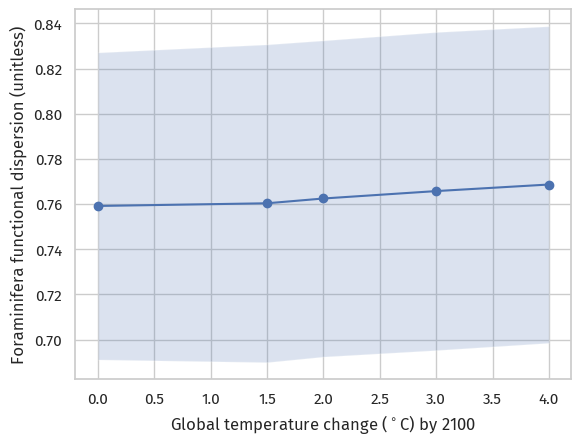

In [15]:
mod_paths = [
    "../model/GMD_test",
    "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.2deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.3deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]

x_label = [0, 1.5, 2, 3, 4]
y_label = []
y_errbar = []

for i, ipath in enumerate(mod_paths):
    foram_community = fm(ipath).select_foram_community("biomass")
    fd_mean = foram_community.dispersion().nanmean()
    fd_sd = foram_community.dispersion().nansd()

    y_label.append(fd_mean)
    y_errbar.append(fd_sd)

y_label = np.array(y_label)
y_errbar = np.array(y_errbar)

plt.plot(x_label, y_label, marker="o")
plt.fill_between(x_label, y_label - y_errbar , y_label + y_errbar, alpha=0.2)
plt.xlabel(r"Global temperature change ($^\circ$C) by 2100")
plt.ylabel("Foraminifera functional dispersion (unitless)")

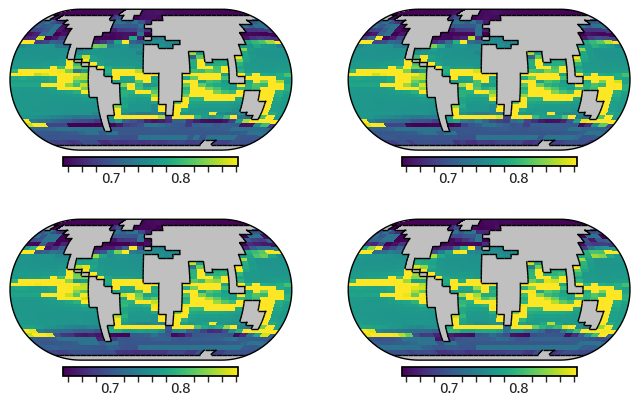

In [16]:
mod_paths = [
    "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.2deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.3deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]

year = [2099.5, 1999.5, 1919.5, 1879.5]
year_index = [-1, -5, -8, -10]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5),
                        subplot_kw={'projection': ccrs.EckertIV()})

for i, ipath in enumerate(mod_paths):
    foram_community = fm(ipath).select_foram_community("biomass")
    foram_community.dispersion().plot_map(ax=axs.flat[i], cmap="viridis")